# _Perceptron_

Tot nu toe hebben we het gehad over het lineaire regressiemodel en de verschillende manieren om de parameters te schatten. We hebben ook gezien hoe het {ref}`logistische regressiemodel <target-logistic-regression>` een uitbreiding is voor binaire klassificatie, waarbij een sigmoïde (S-vormige) functie (de _link functie_) lineaire predicties vertaalt naar het interval $[0, 1]$. Het logistische regressiemodel is een specifiek geval van een _{ref}`generalized linear model <target-glm>`_. 

In deze sectie introduceren we het **perceptron**, de bouwsteen van neurale netwerken. Een perceptron is conceptueel zeer verwant aan _generalized linear models_. Het belangrijkste verschil zit in de terminologie: wat we bij GLMs een _link functie_ noemen, wordt in de context van neurale netwerken een _activatiefunctie_ genoemd.

(target-perceptron)=
**Een perceptron is in feite een kunstmatig neuron dat de werking van een biologisch neuron nabootst**:
- De inputs $x_i$ zijn vergelijkbaar met signalen van andere neuronen
- De gewichten $w_i$ bepalen de sterkte van elke verbinding
- De activatiefunctie $\phi(z)$ bepaalt of het neuron "vuurt" (actief wordt)

[![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/Neuron3.png/400px-Neuron3.png?raw=true)](https://en.wikipedia.org/wiki/Artificial_neuron)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.patches import Circle, FancyArrowPatch, Patch
from torch import nn, optim

from ml_courses.sim import generate_binary_tipping_data

## Anatomie

Een perceptron bestaat uit:

1. Inputlaag (_input layer_): De feature waarden $x_1, x_2, \ldots, x_n$ (net zoals bij regressie)
2. Gewichten (_weights_): De parameters $w_1, w_2, \ldots, w_n$ (analoog aan de coëfficiënten $b_1, b_2, \ldots, b_n$ bij regressie)
3. _Bias_: De parameter $w_1$ (analoog aan het intercept $b_1$ bij regressie), waarbij $x_1=1$
4. Lineaire combinatie: $z = \sum_{i=1}^{n} w_i x_i = \pmb{x}^T\pmb{w}$
5. Activatiefunctie: $\phi(z)$ die de lineaire output niet-lineair transformeert
6. Output: De uiteindelijke predictie $\hat{y}^B = O(\phi(z))$

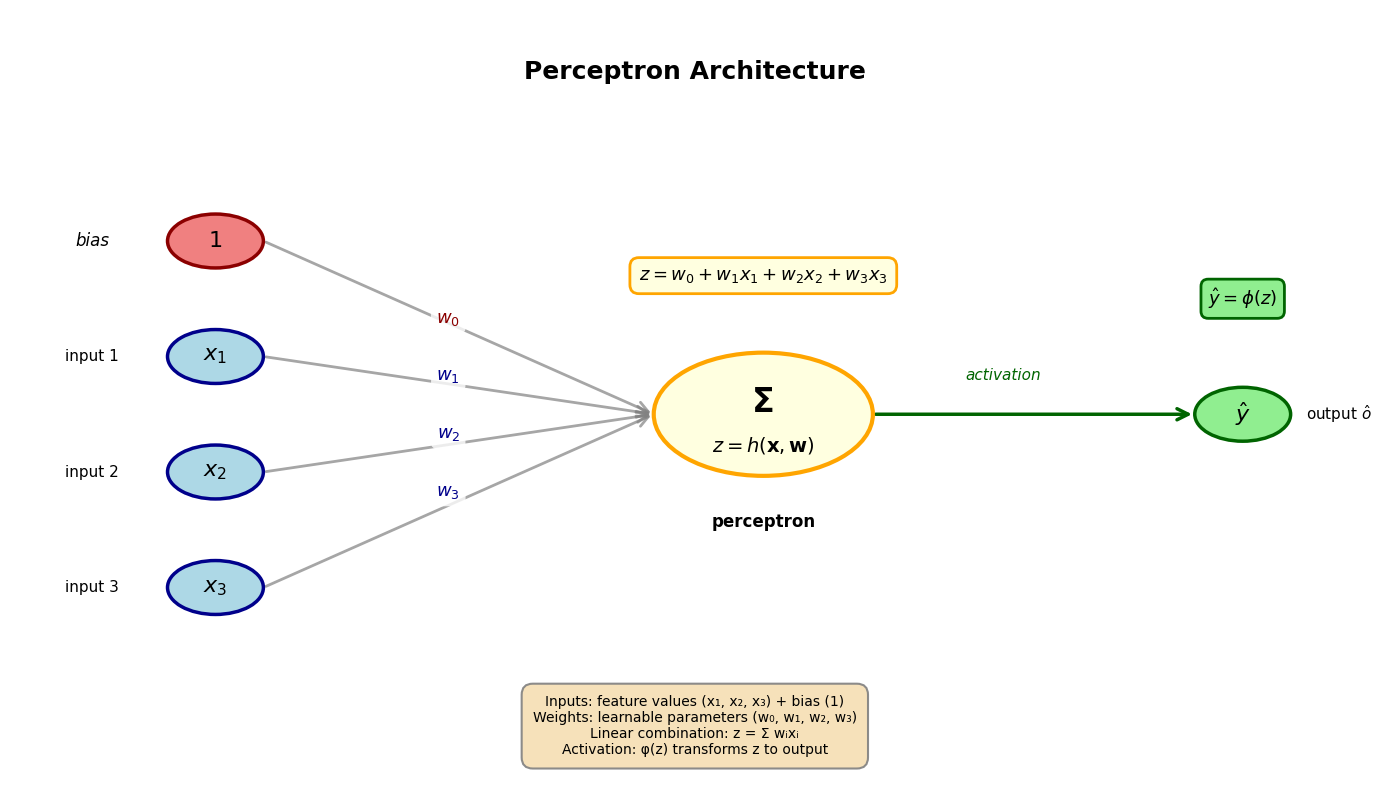

In [ ]:
# Visualize the perceptron architecture
fig, ax = plt.subplots(figsize=(14, 8))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis("off")

# Define positions
input_y_positions = [7, 5.5, 4, 2.5]
input_x = 1.5
neuron_x = 5.5
output_x = 9

# Draw input nodes
input_nodes = []
for i, y_pos in enumerate(input_y_positions):
    if i == 0:
        # Bias node (special)
        circle = Circle(
            (input_x, y_pos), 0.35, color="lightcoral", ec="darkred", linewidth=2.5, zorder=3
        )
        ax.text(
            input_x,
            y_pos,
            "$1$",
            ha="center",
            va="center",
            fontsize=16,
            fontweight="bold",
            zorder=4,
        )
        ax.text(input_x - 0.9, y_pos, "bias", ha="center", va="center", fontsize=12, style="italic")
    else:
        # Regular input nodes
        circle = Circle(
            (input_x, y_pos), 0.35, color="lightblue", ec="darkblue", linewidth=2.5, zorder=3
        )
        ax.text(
            input_x,
            y_pos,
            f"$x_{i}$",
            ha="center",
            va="center",
            fontsize=16,
            fontweight="bold",
            zorder=4,
        )
        ax.text(input_x - 0.9, y_pos, f"input {i}", ha="center", va="center", fontsize=11)

    ax.add_patch(circle)
    input_nodes.append((input_x, y_pos))

# Draw neuron (perceptron)
neuron_center_y = 4.75
neuron = Circle(
    (neuron_x, neuron_center_y), 0.8, color="lightyellow", ec="orange", linewidth=3, zorder=3
)
ax.add_patch(neuron)

# Add sigma symbol and function label
ax.text(
    neuron_x,
    neuron_center_y + 0.15,
    "Σ",
    ha="center",
    va="center",
    fontsize=24,
    fontweight="bold",
    zorder=4,
)
ax.text(
    neuron_x,
    neuron_center_y - 0.4,
    "$z = h(\mathbf{x}, \mathbf{w})$",
    ha="center",
    va="center",
    fontsize=14,
    style="italic",
    zorder=4,
)
ax.text(
    neuron_x,
    neuron_center_y - 1.4,
    "perceptron",
    ha="center",
    va="center",
    fontsize=12,
    fontweight="bold",
)

# Draw output node
output_node = Circle(
    (output_x, neuron_center_y), 0.35, color="lightgreen", ec="darkgreen", linewidth=2.5, zorder=3
)
ax.add_patch(output_node)
ax.text(
    output_x,
    neuron_center_y,
    r"$\hat{y}$",
    ha="center",
    va="center",
    fontsize=16,
    fontweight="bold",
    zorder=4,
)
ax.text(
    output_x + 0.7, neuron_center_y, "output " + r"$\hat{o}$", ha="center", va="center", fontsize=11
)

# Draw connections from inputs to neuron with weights
for i, (x, y) in enumerate(input_nodes):
    arrow = FancyArrowPatch(
        (x + 0.35, y),
        (neuron_x - 0.8, neuron_center_y),
        arrowstyle="->",
        mutation_scale=20,
        linewidth=2,
        color="gray",
        alpha=0.7,
        zorder=1,
    )
    ax.add_patch(arrow)

    # Add weight labels
    mid_x = (x + neuron_x) / 2 - 0.3
    mid_y = (y + neuron_center_y) / 2
    ax.text(
        mid_x,
        mid_y,
        f"$w_{i}$",
        ha="center",
        va="bottom",
        fontsize=13,
        color="darkred" if i == 0 else "darkblue",
        fontweight="bold",
        bbox={"boxstyle": "round,pad=0.3", "facecolor": "white", "edgecolor": "none", "alpha": 0.8},
    )

# Draw connection from neuron to output
arrow = FancyArrowPatch(
    (neuron_x + 0.8, neuron_center_y),
    (output_x - 0.35, neuron_center_y),
    arrowstyle="->",
    mutation_scale=20,
    linewidth=2.5,
    color="darkgreen",
    zorder=2,
)
ax.add_patch(arrow)

# Add activation function label above arrow
ax.text(
    (neuron_x + output_x) / 2,
    neuron_center_y + 0.4,
    "activation",
    ha="center",
    va="bottom",
    fontsize=11,
    style="italic",
    color="darkgreen",
)

# Add formula annotations
# Linear combination
ax.text(
    neuron_x,
    neuron_center_y + 1.8,
    r"$z = w_0 + w_1x_1 + w_2x_2 + w_3x_3$",
    ha="center",
    va="center",
    fontsize=13,
    bbox={
        "boxstyle": "round,pad=0.5",
        "facecolor": "lightyellow",
        "edgecolor": "orange",
        "linewidth": 2,
    },
)

# Output formula
ax.text(
    output_x,
    neuron_center_y + 1.5,
    r"$\hat{y} = \phi(z)$",
    ha="center",
    va="center",
    fontsize=13,
    bbox={
        "boxstyle": "round,pad=0.4",
        "facecolor": "lightgreen",
        "edgecolor": "darkgreen",
        "linewidth": 2,
    },
)

# Add title
ax.text(5, 9.2, "Perceptron Architecture", ha="center", va="center", fontsize=18, fontweight="bold")

# Add legend/explanation box
legend_elements = [
    "Inputs: feature values (x₁, x₂, x₃) + bias (1)",
    "Weights: learnable parameters (w₀, w₁, w₂, w₃)",
    "Linear combination: z = Σ wᵢxᵢ",
    "Activation: φ(z) transforms z to output",
]
ax.text(
    5,
    0.7,
    "\n".join(legend_elements),
    ha="center",
    va="center",
    fontsize=10,
    bbox={
        "boxstyle": "round,pad=0.8",
        "facecolor": "wheat",
        "edgecolor": "gray",
        "linewidth": 1.5,
        "alpha": 0.9,
    },
)

plt.tight_layout()
plt.show()

## Activatiefuncties
(target-activation)=
De **activatiefunctie** $\phi(z)$ is cruciaal voor de werking van een perceptron. Ze **vertaalt de lineaire combinatie van inputs en gewichten naar een output via een niet-lineaire transformatie die bepaalt of en in welke mate het perceptron actief wordt**. Er bestaan verschillende varianten met verschillende eigenschappen. Hieronder bekijken we de meest gebruikelijke:

### 1. Logistische
De logistische functie is een S-vormige functie die we al kennen van het logistische regressiemodel:

$$
\phi(z) = \sigma(z) = \frac{1}{1 + e^{-z}}
$$

- Bereik: $(0, 1)$
- De lineaire combinatie $z$ noemen we ook _{ref}`=logits <target-logits>`_ in deze context 
- Gebruik: Binaire klassificatie (output kan als probabiliteit geïnterpreteerd worden)

### 2. _Tanh_ (Hyperbolische tangens)
Dit is ook een S-vormige functie die tussen -1 en 1 schaalt:

$$
\phi(z) = \tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}
$$

- Bereik: $(-1, 1)$
- Voordeel: Zero-centered (gemiddelde output rond 0)

### 3. ReLU (Rectified Linear Unit)
**ReLU** is een _piecewise linear_ functie en is de meest populaire activatiefunctie in moderne neurale netwerken:

$$
\phi(z) = \max(0, z) = \begin{cases} z & \text{als } z > 0 \\ 0 & \text{als } z \leq 0 \end{cases}
$$

- Bereik: $[0, +\infty)$
- Voordelen: Computationeel efficiënt, helpt _vanishing gradients_ reduceren (zie verder)

### 4. GeLU (Gaussian Error Linear Unit)
GeLU is een continue variant van ReLU die steeds populairder wordt, vooral in de _transformer_ modellen:

$$
\phi(z) = z \cdot \Phi(z) \approx 0.5z\left(1 + \tanh\left[\sqrt{\frac{2}{\pi}}\left(z + 0.044715z^3\right)\right]\right)
$$

waar $\Phi(z)$ de cumulatieve distributie van de standaard normaalverdeling of _Gauss_ verdeling is.

- Bereik: $(-\infty, +\infty)$
- Voordelen: Continue differentieerbaar, niet-monotoon (kan negatieve waarden hebben)

### 4. Step function (Klassiek perceptron)
De originele activatiefunctie van het perceptron [](https://doi.org/10.1037%2Fh0042519):

$$
\phi(z) = \begin{cases} 1 & \text{als } z > 0 \\ 0 & \text{als } z \leq 0 \end{cases}
$$

- Bereik: $\{0, 1\}$
- Probleem: Niet differentieerbaar, dus niet bruikbaar met gradient descent

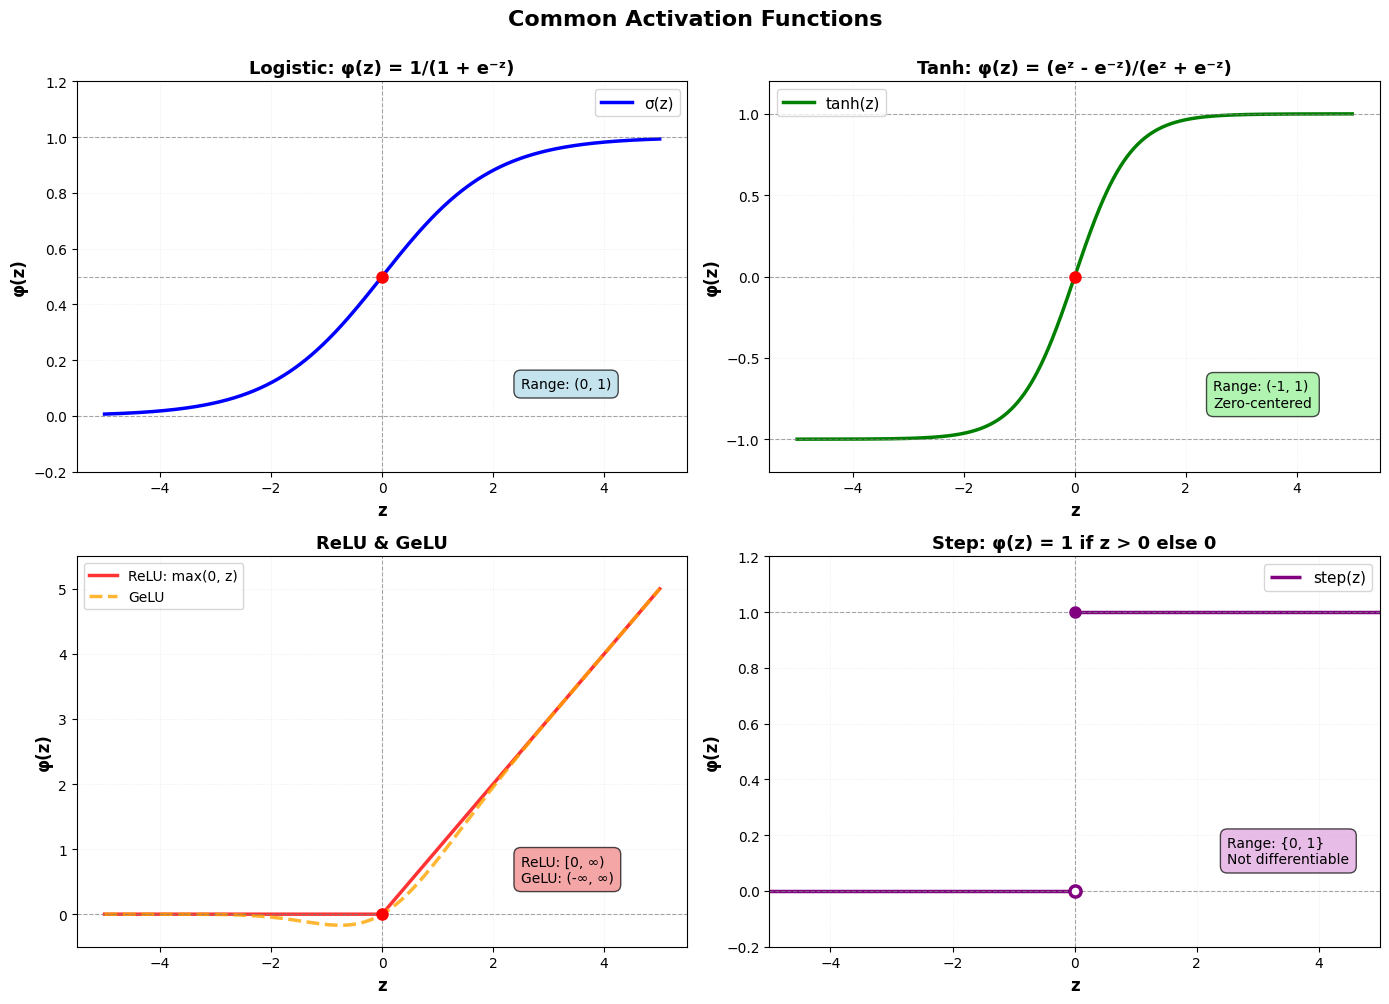

In [ ]:
# Visualize different activation functions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Generate x values
x = np.linspace(-5, 5, 1000)

# 1. Logistic (Sigmoid)
ax = axes[0]
y_sigmoid = 1 / (1 + np.exp(-x))
ax.plot(x, y_sigmoid, "b-", linewidth=2.5, label="σ(z)")
ax.axhline(y=0, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)
ax.axhline(y=0.5, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)
ax.axhline(y=1, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)
ax.axvline(x=0, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)
ax.plot(0, 0.5, "ro", markersize=8, zorder=5)
ax.set_xlabel("z", fontsize=12, fontweight="bold")
ax.set_ylabel("φ(z)", fontsize=12, fontweight="bold")
ax.set_title("Logistic: φ(z) = 1/(1 + e⁻ᶻ)", fontsize=13, fontweight="bold")
ax.set_ylim(-0.2, 1.2)
ax.grid(True, alpha=0.3, linestyle=":", linewidth=0.5)
ax.legend(fontsize=11)
ax.text(
    2.5,
    0.1,
    "Range: (0, 1)",
    fontsize=10,
    bbox={"boxstyle": "round,pad=0.5", "facecolor": "lightblue", "alpha": 0.7},
)

# 2. Tanh
ax = axes[1]
y_tanh = np.tanh(x)
ax.plot(x, y_tanh, "g-", linewidth=2.5, label="tanh(z)")
ax.axhline(y=0, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)
ax.axhline(y=1, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)
ax.axhline(y=-1, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)
ax.axvline(x=0, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)
ax.plot(0, 0, "ro", markersize=8, zorder=5)
ax.set_xlabel("z", fontsize=12, fontweight="bold")
ax.set_ylabel("φ(z)", fontsize=12, fontweight="bold")
ax.set_title("Tanh: φ(z) = (eᶻ - e⁻ᶻ)/(eᶻ + e⁻ᶻ)", fontsize=13, fontweight="bold")
ax.set_ylim(-1.2, 1.2)
ax.grid(True, alpha=0.3, linestyle=":", linewidth=0.5)
ax.legend(fontsize=11)
ax.text(
    2.5,
    -0.8,
    "Range: (-1, 1)\nZero-centered",
    fontsize=10,
    bbox={"boxstyle": "round,pad=0.5", "facecolor": "lightgreen", "alpha": 0.7},
)

# 3. ReLU and GeLU
ax = axes[2]
y_relu = np.maximum(0, x)
# GeLU approximation: 0.5 * x * (1 + tanh(sqrt(2/pi) * (x + 0.044715 * x^3)))
y_gelu = 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))
ax.plot(x, y_relu, "r-", linewidth=2.5, label="ReLU: max(0, z)", alpha=0.8)
ax.plot(x, y_gelu, "orange", linewidth=2.5, linestyle="--", label="GeLU", alpha=0.8)
ax.axhline(y=0, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)
ax.axvline(x=0, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)
ax.plot(0, 0, "ro", markersize=8, zorder=5)
ax.set_xlabel("z", fontsize=12, fontweight="bold")
ax.set_ylabel("φ(z)", fontsize=12, fontweight="bold")
ax.set_title("ReLU & GeLU", fontsize=13, fontweight="bold")
ax.set_ylim(-0.5, 5.5)
ax.grid(True, alpha=0.3, linestyle=":", linewidth=0.5)
ax.legend(fontsize=10, loc="upper left")
ax.text(
    2.5,
    0.5,
    "ReLU: [0, ∞)\nGeLU: (-∞, ∞)",
    fontsize=10,
    bbox={"boxstyle": "round,pad=0.5", "facecolor": "lightcoral", "alpha": 0.7},
)

# 4. Step function
ax = axes[3]
x_step = np.linspace(-5, 5, 2)
y_step_neg = np.zeros_like(x_step[x_step < 0])
y_step_pos = np.ones_like(x_step[x_step >= 0])
ax.hlines(0, -5, 0, colors="purple", linewidth=2.5, label="step(z)")
ax.hlines(1, 0, 5, colors="purple", linewidth=2.5)
ax.plot(
    0, 0, "o", color="purple", markersize=8, markerfacecolor="white", markeredgewidth=2.5, zorder=5
)
ax.plot(0, 1, "o", color="purple", markersize=8, zorder=5)
ax.axhline(y=0, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)
ax.axhline(y=1, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)
ax.axvline(x=0, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)
ax.set_xlabel("z", fontsize=12, fontweight="bold")
ax.set_ylabel("φ(z)", fontsize=12, fontweight="bold")
ax.set_title("Step: φ(z) = 1 if z > 0 else 0", fontsize=13, fontweight="bold")
ax.set_ylim(-0.2, 1.2)
ax.set_xlim(-5, 5)
ax.grid(True, alpha=0.3, linestyle=":", linewidth=0.5)
ax.legend(fontsize=11)
ax.text(
    2.5,
    0.1,
    "Range: {0, 1}\nNot differentiable",
    fontsize=10,
    bbox={"boxstyle": "round,pad=0.5", "facecolor": "plum", "alpha": 0.7},
)

plt.suptitle("Common Activation Functions", fontsize=16, fontweight="bold", y=1.00)
plt.tight_layout()
plt.show()

## Analogie met logistische regressie

Als we bij een perceptron (a) voor de logistische activatiefunctie kiezen, en (b) de wiskundige notatie voor de volledige input $\pmb{X}$ data gebruiken, krijgen we enkel een verschil in benaming tussen de perceptron en logistische regressie formulering.  
- Logistische regressie:

$$
\begin{align}
\pmb{\hat{y}} &= \sigma(\pmb{X}\pmb{b}) \cr
&= \frac{1}{1 + e^{-\pmb{X}\pmb{b}}}
\end{align}
$$

- Perceptron

$$
\begin{align}
\pmb{\hat{y}} &= \phi(\pmb{X}\pmb{w}) \cr
&= \frac{1}{1 + e^{-\pmb{X}\pmb{w}}}
\end{align}
$$

💡 We kunnen dus exact dezelfde gradient descent oplossing gebruiken!  

Hieronder illustreren we dit, gebruikmakend van PyTorch en PyTorch's automatische gradiëntberekening (autograd). We gebruiken dezelfde gesimuleerde data als in het {ref}`logistische regressie voorbeeld <target-bin-sim>`.

In [4]:
# Generate the same tipping data as in the GLM notebook
X, y, metadata = generate_binary_tipping_data(n_customers=50, seed=42)

print("COFFEE SHOP TIPPING ANALYSIS (BINARY)")
print("=" * 50)
print(f"Dataset size: {len(y)} customers")
print(f"Order range: ${metadata['order_totals'].min():.2f} - ${metadata['order_totals'].max():.2f}")
print(f"Tippers: {metadata['n_tippers']} ({100 * metadata['tip_rate']:.1f}%)")
print(f"Non-tippers: {len(y) - metadata['n_tippers']} ({100 * (1 - metadata['tip_rate']):.1f}%)")
print("\nTrue model parameters:")
print(f"  Intercept (b₀): {metadata['true_b1']:.3f}")
print(f"  Slope (b₁):     {metadata['true_b2']:.3f}")
print(f"  P(tip) = σ({metadata['true_b1']:.2f} + {metadata['true_b2']:.2f} × order_total)")

COFFEE SHOP TIPPING ANALYSIS (BINARY)
Dataset size: 50 customers
Order range: $3.96 - $24.46
Tippers: 43 (86.0%)
Non-tippers: 7 (14.0%)

True model parameters:
  Intercept (b₀): -2.000
  Slope (b₁):     0.250
  P(tip) = σ(-2.00 + 0.25 × order_total)


We trainen een perceptron met logistische activatiefunctie via gradient descent, gebruikmakend van PyTorch's ingebouwde functionaliteit:

- `torch.nn.Linear`: Een lineaire laag die $z = \pmb{x}^T\pmb{w} + b$ berekent
- `torch.nn.Sigmoid`: De logistische activatiefunctie $\sigma(z)$  
- `torch.nn.BCELoss`: De binary cross-entropy loss functie
- `torch.optim.SGD`: Stochastic gradient descent optimizer (met autograd!)

Deze aanpak is equivalent aan logistische regressie maar gebruikt de terminologie en tools van neurale netwerken.

In [5]:
# Define a simple perceptron model
# This is a single neuron: Linear layer + Sigmoid activation
class SimplePerceptron(nn.Module):
    """A simple perceptron model with sigmoid activation.

    This is a single neuron: Linear layer + Sigmoid activation.
    Note that PyTorch's nn.Linear already includes bias by default.
    """

    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)  # w^T x + b
        self.sigmoid = nn.Sigmoid()  # σ(z)

    def forward(self, x):
        """Perform forward pass through the perceptron.

        Args:
            x: Input tensor of shape (batch_size, input_dim)

        Returns
        -------
            Output tensor of shape (batch_size, 1) with sigmoid activation applied
        """
        z = self.linear(x)  # Linear combination
        y_hat = self.sigmoid(z)  # Apply activation
        return y_hat

In [6]:
# Convert numpy arrays to PyTorch tensors
X_torch = torch.tensor(X, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

# Initialize model
model = SimplePerceptron(input_dim=1)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Stochastic Gradient Descent

# Training loop
n_iterations = 50000
loss_history = []

for i in range(n_iterations):
    # Forward pass: compute predictions
    y_pred = model(X_torch)

    # Compute loss
    loss = criterion(y_pred, y_torch)

    # Backward pass: compute gradients (autograd!)
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()  # Compute gradients via backpropagation

    # Update parameters
    optimizer.step()

    # Store loss for visualization
    loss_history.append(loss.item())

    if (i + 1) % 10000 == 0:
        print(f"Iteration {i + 1}/{n_iterations}, Loss: {loss.item():.4f}")

# Extract learned parameters
learned_b0 = model.linear.bias.item()
learned_b1 = model.linear.weight.item()

print(f"\n{'=' * 60}")
print("RESULTS: PyTorch Perceptron (Logistic Activation)")
print(f"{'=' * 60}")
print("Learned parameters:")
print(f"  Intercept (b₀): {learned_b0:.3f}")
print(f"  Slope (b₁):     {learned_b1:.3f}")
print("\nTrue parameters:")
print(f"  Intercept (b₀): {metadata['true_b1']:.3f}")
print(f"  Slope (b₁):     {metadata['true_b2']:.3f}")
print(f"\nFinal loss: {loss_history[-1]:.4f}")
print(f"{'=' * 60}")

Iteration 10000/50000, Loss: 0.2763
Iteration 20000/50000, Loss: 0.2740
Iteration 30000/50000, Loss: 0.2738
Iteration 40000/50000, Loss: 0.2738
Iteration 50000/50000, Loss: 0.2738

RESULTS: PyTorch Perceptron (Logistic Activation)
Learned parameters:
  Intercept (b₀): -1.908
  Slope (b₁):     0.336

True parameters:
  Intercept (b₀): -2.000
  Slope (b₁):     0.250

Final loss: 0.2738


## ⚠️ Beperking
(target-linear-separable)=
Een _enkelvoudig_ perceptron kan alleen **lineair scheidbare** klassen leren. De beslissingsgrens is altijd een rechte lijn (in 2D), een vlak (in 3D), of een _hyper surface_ (in 4+D). Het klassieke voorbeeld van een niet-lineair scheidbaar probleem is de _XOR_-functie (exclusive OR).

In [7]:
# XOR problem
X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
y_xor = np.array([0, 1, 1, 0], dtype=np.float32)  # XOR: output is 1 when inputs differ

# Convert to PyTorch tensors
X_xor_torch = torch.tensor(X_xor, dtype=torch.float32)
y_xor_torch = torch.tensor(y_xor, dtype=torch.float32).reshape(-1, 1)

# Train a perceptron on XOR using PyTorch
model_xor = SimplePerceptron(input_dim=2)
criterion_xor = nn.BCELoss()
optimizer_xor = optim.SGD(model_xor.parameters(), lr=0.1)

n_iterations_xor = 10000
for _ in range(n_iterations_xor):
    y_pred = model_xor(X_xor_torch)
    loss = criterion_xor(y_pred, y_xor_torch)
    optimizer_xor.zero_grad()
    loss.backward()
    optimizer_xor.step()

# Get predictions
with torch.no_grad():
    y_pred_xor_prob = model_xor(X_xor_torch).numpy().flatten()
    y_pred_xor = (y_pred_xor_prob >= 0.5).astype(int)

accuracy_xor = np.mean(y_pred_xor == y_xor)

print("XOR Problem:")
print(f"Perceptron accuracy: {accuracy_xor:.2%}")
print("\nPredictions vs True labels:")
for x, y_true, y_pred in zip(X_xor, y_xor, y_pred_xor, strict=True):
    status = "✓" if y_true == y_pred else "✗"
    print(f"  Input: {x} → True: {int(y_true)}, Predicted: {y_pred} {status}")

XOR Problem:
Perceptron accuracy: 50.00%

Predictions vs True labels:
  Input: [0. 0.] → True: 0, Predicted: 1 ✗
  Input: [0. 1.] → True: 1, Predicted: 1 ✓
  Input: [1. 0.] → True: 1, Predicted: 1 ✓
  Input: [1. 1.] → True: 0, Predicted: 1 ✗


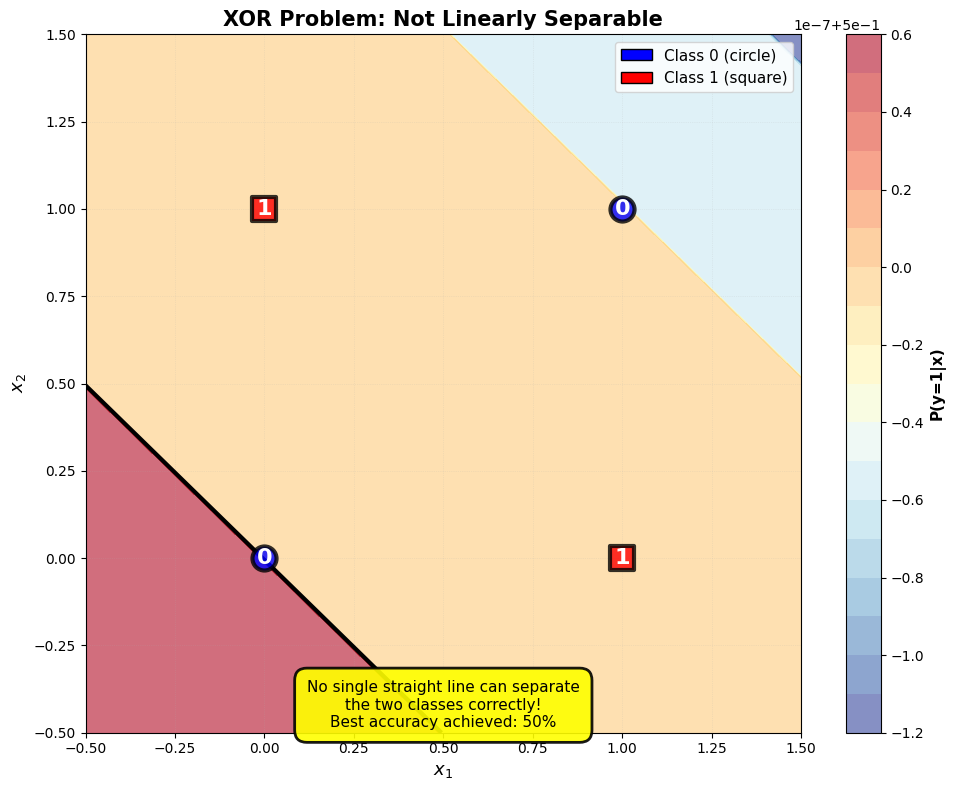

In [8]:
# Visualize XOR problem and why it fails
fig, ax = plt.subplots(figsize=(10, 8))

# Create mesh for decision boundary
x_min, x_max = -0.5, 1.5
y_min, y_max = -0.5, 1.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Predict on mesh using PyTorch model
with torch.no_grad():
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    Z = model_xor(grid_points).numpy().flatten()
    Z = Z.reshape(xx.shape)

# Plot contour
contour = ax.contourf(xx, yy, Z, levels=20, cmap="RdYlBu_r", alpha=0.6)
contour_line = ax.contour(xx, yy, Z, levels=[0.5], colors="black", linewidths=3)

# Plot XOR points
colors = ["blue" if y == 0 else "red" for y in y_xor]
for i, (x, y, color) in enumerate(zip(X_xor, y_xor, colors, strict=True)):
    marker = "o" if y == 0 else "s"
    ax.scatter(
        x[0],
        x[1],
        c=color,
        s=300,
        alpha=0.8,
        edgecolors="black",
        linewidth=3,
        marker=marker,
        zorder=5,
    )
    # Add labels
    ax.text(
        x[0],
        x[1],
        f"{int(y)}",
        ha="center",
        va="center",
        fontsize=16,
        fontweight="bold",
        color="white",
        zorder=6,
    )

# Add colorbar
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label("P(y=1|x)", fontsize=11, fontweight="bold")

# Labels and styling
ax.set_xlabel("$x_1$", fontsize=13, fontweight="bold")
ax.set_ylabel("$x_2$", fontsize=13, fontweight="bold")
ax.set_title("XOR Problem: Not Linearly Separable", fontsize=15, fontweight="bold")
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.grid(True, alpha=0.3, linestyle=":", linewidth=0.5)

# Add legend
legend_elements = [
    Patch(facecolor="blue", edgecolor="black", label="Class 0 (circle)"),
    Patch(facecolor="red", edgecolor="black", label="Class 1 (square)"),
]
ax.legend(handles=legend_elements, fontsize=11, loc="upper right")

# Add explanation text
explanation = (
    "No single straight line can separate\n"
    "the two classes correctly!\n"
    f"Best accuracy achieved: {accuracy_xor:.0%}"
)
ax.text(
    0.5,
    -0.35,
    explanation,
    ha="center",
    va="top",
    fontsize=11,
    bbox={
        "boxstyle": "round,pad=0.8",
        "facecolor": "yellow",
        "edgecolor": "black",
        "linewidth": 2,
        "alpha": 0.9,
    },
)

plt.tight_layout()
plt.show()

De oplossing voor het XOR-probleem (en andere niet-lineaire problemen) is om _meerdere perceptrons te combineren_.